# Game of Thrones EDA

In [2]:
# Data Cleaning and wrangling
from pandas import DataFrame, read_csv, concat, factorize
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline
sns.set_style("white")

# time module
import time

# regex module
import re

# import counter
from collections import Counter

# Predictive Analysis
from xgboost import plot_importance
from xgboost import XGBClassifier as XGBC
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

/home/sharmas/anaconda2/envs/greyatom/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [4]:
def timeit(method):
    ''' To check the execution time
        Parameter
        ---------
        method: function
        Return
        ---------
        float number
    '''
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [5]:
@timeit
def load_csv(name):
    ''' loads the dataset
        Parameter:
        ----------
        method: string
        Return
        ----------
        dataframe
    '''
    try:
        filepath = "./" +name+ '.csv'
        if name == 'battles':
            return read_csv(filepath)
        elif name == 'character-deaths':
            return read_csv(filepath)
        elif name == 'character-predictions':
            return read_csv(filepath)
        else:
            pass
    except IOError:
        raise "File not Found 404"

battles = load_csv('battles')
character_deaths = load_csv('character-deaths')
character_predictions = load_csv('character-predictions')

'load_csv'  7.61 ms
'load_csv'  5.30 ms
'load_csv'  16.22 ms


In [6]:
battles.columns

Index([u'name', u'year', u'battle_number', u'attacker_king', u'defender_king',
       u'attacker_1', u'attacker_2', u'attacker_3', u'attacker_4',
       u'defender_1', u'defender_2', u'defender_3', u'defender_4',
       u'attacker_outcome', u'battle_type', u'major_death', u'major_capture',
       u'attacker_size', u'defender_size', u'attacker_commander',
       u'defender_commander', u'summer', u'location', u'region', u'note'],
      dtype='object')

In [7]:
# battles['attcker_number'] = []
@timeit
def new_features(dataframe1, dataframe2):
    ''' Creates New Features in both the dataframes
        Parameters
        -----------
        method: dataframes
        Return
        -----------
        None
    '''
    dataframe1.loc[:, 'attacker_count'] = (4 - battles[['attacker_1','attacker_2', 'attacker_3', \
                                              'attacker_4']].isnull().sum(axis=1))
    dataframe1.loc[:, 'defender_count'] = (4 - battles[['defender_1','defender_2', 'defender_3', \
                                              'defender_4']].isnull().sum(axis=1))
    dataframe1.loc[:, 'att_comm_count'] = [len(x) if type(x) == list else np.nan for \
                                        x in battles.attacker_commander.str.split(',')]
    dataframe2.loc[:, 'no_of_books'] = character_predictions[[x for x in \
                                                                character_predictions.columns \
                                                            if x.startswith('book')]].sum(axis=1)
    
new_features(battles, character_predictions)

'new_features'  12.59 ms


In [8]:
battles.columns

Index([u'name', u'year', u'battle_number', u'attacker_king', u'defender_king',
       u'attacker_1', u'attacker_2', u'attacker_3', u'attacker_4',
       u'defender_1', u'defender_2', u'defender_3', u'defender_4',
       u'attacker_outcome', u'battle_type', u'major_death', u'major_capture',
       u'attacker_size', u'defender_size', u'attacker_commander',
       u'defender_commander', u'summer', u'location', u'region', u'note',
       u'attacker_count', u'defender_count', u'att_comm_count'],
      dtype='object')

In [9]:
battles.att_comm_count.value_counts()

1.0    15
2.0    13
3.0     5
6.0     2
5.0     2
Name: att_comm_count, dtype: int64

In [10]:
character_predictions.iloc[:, 16:21].head()

book1  book2  book3  book4  book5
0      0      0      0      0      0
1      1      1      1      1      1
2      0      0      0      1      0
3      0      0      0      0      0
4      0      0      0      1      0

# Exploratory Data Analysis

## Army Size and Outcome

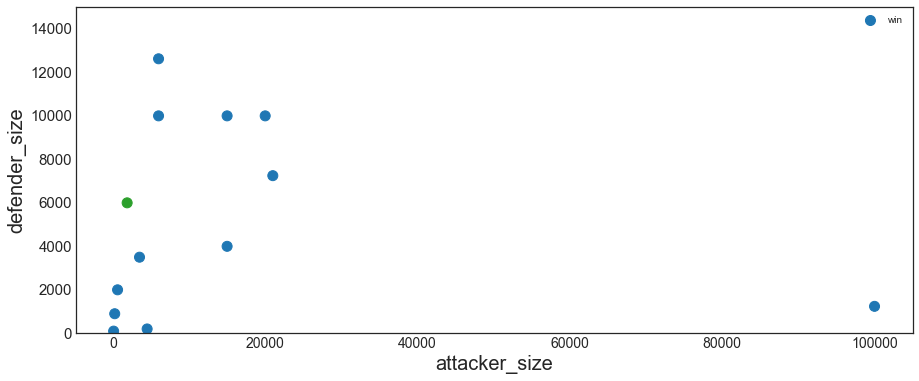

In [15]:
data = battles.dropna(subset=['attacker_size', 'defender_size', 'attacker_outcome'], axis=0).copy(deep=True)
color = [sns.color_palette()[0] if x=='win' else sns.color_palette()[2] for x in battles.attacker_outcome.values]
p = data.plot.scatter('attacker_size', 'defender_size', c=color, s=100)
_ = p.set(ylim=[0, 15000], xlabel="attacker_size", ylabel="defender_size"), p.legend(['win', 'loss'])
_ = plt.savefig('./plots_and_graphs/Army_Size_Outcome.jpeg', bbox_inches='tight')

## Major Death/ Capture by year

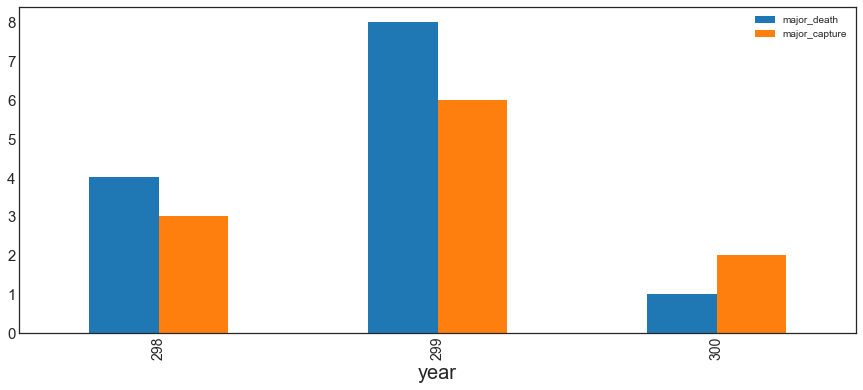

In [16]:
p = battles.groupby('year')[['major_death', 'major_capture']].sum().plot(kind='bar')
_ = plt.savefig('./plots_and_graphs/Death_Capture.jpeg', bbox_inches='tight')

## One Major house on attacking side

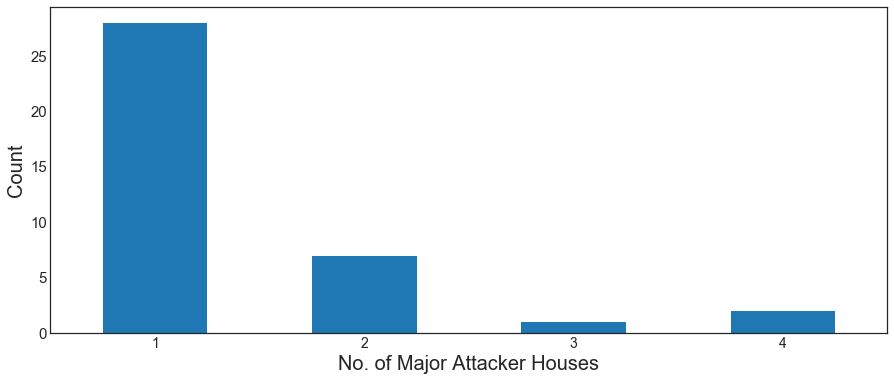

In [45]:
# c = list(tuple([set(x) for x in battles.attacker_commander.values() if len(set(x)) > 1]))
p = battles.attacker_count.value_counts().sort_index().plot.bar(rot = 0)
_ = p.set(xlabel = "No. of Major Attacker Houses", ylabel = "Count")
_ = plt.savefig('./plots_and_graphs/Major_House_Attacking_Side.jpeg', bbox_inches='tight')

## Pair with most fought battle

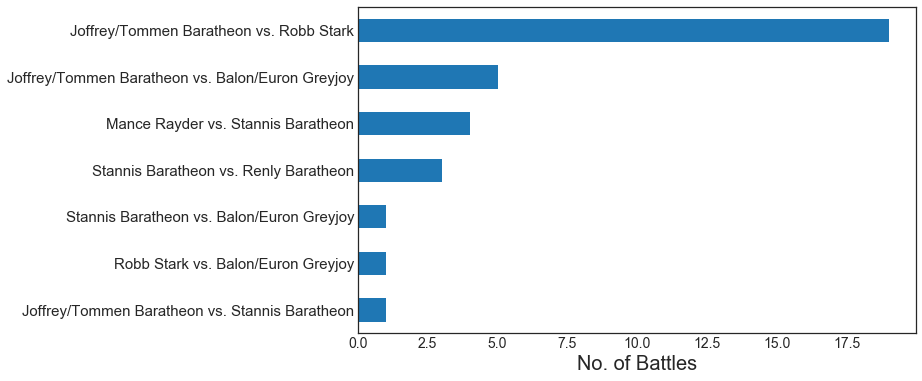

In [46]:
# Counter is used for tallies and is imported from collections package.It returns a dictionary
c = list(Counter([tuple(set(x)) for x in battles.dropna(subset = ["attacker_king", \
                                                                  "defender_king"]) \
                  [["attacker_king", "defender_king"]].values if len(set(x)) > 1]).items())
p = DataFrame(c).sort_values(1).plot(figsize = (10, 6), kind='barh')
_ = p.set(yticklabels = ["%s vs. %s" % (x[0], x[1]) for x in list(zip(*c))[0]], \
          xlabel = "No. of Battles"), p.legend("")
_ = plt.savefig('./plots_and_graphs/Pair_with_Fought_Battle.jpeg', bbox_inches='tight')

## Army commanders and their Kings

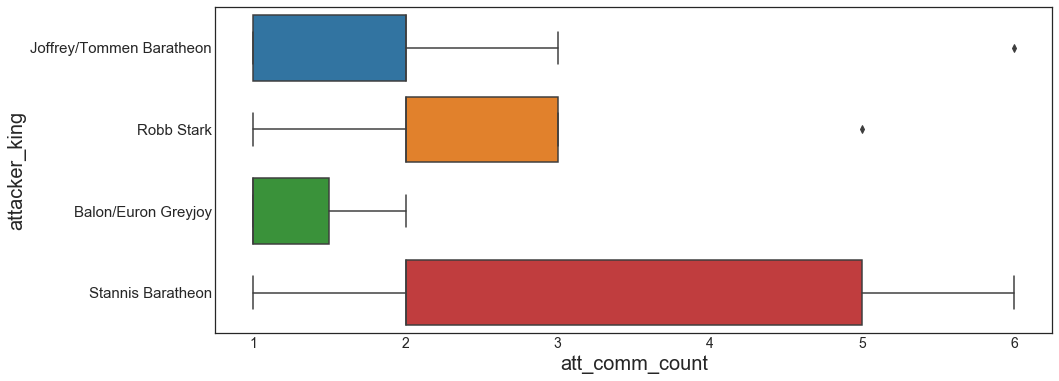

In [47]:
sns.boxplot(battles.att_comm_count, battles.attacker_king , data=battles)
_ = plt.savefig('./plots_and_graphs/Army_Commanders_Kings.jpeg', bbox_inches='tight')

## Death/Capture based on Region

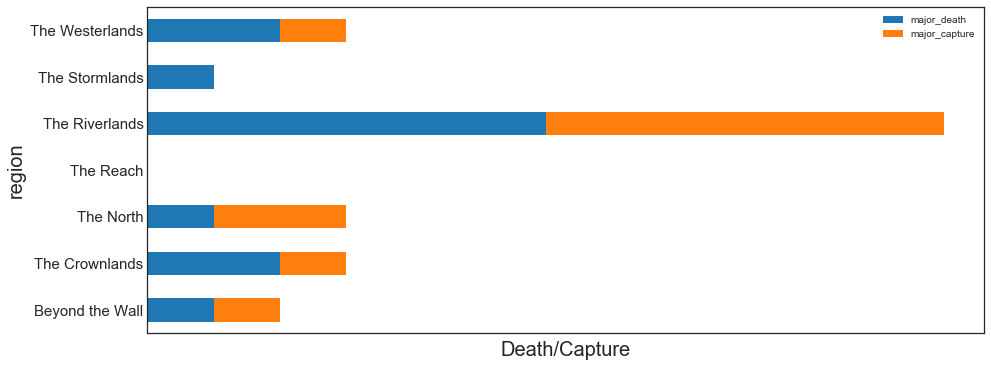

In [48]:
data = battles.groupby('region')[['major_death', 'major_capture']].sum().plot(kind='barh', stacked=True)
data.set(xticklabels='', xlabel='Death/Capture')
_ = plt.savefig('./plots_and_graphs/Death_Capture_Region.jpeg', bbox_inches='tight')

In [49]:
character_predictions.head()


S.No  actual  pred  alive   plod                  name  \
0     1       0     0  0.054  0.946  Viserys II Targaryen   
1     2       1     0  0.387  0.613           Walder Frey   
2     3       1     0  0.493  0.507          Addison Hill   
3     4       0     0  0.076  0.924           Aemma Arryn   
4     5       1     1  0.617  0.383        Sylva Santagar   

                  title  male   culture  dateOfBirth     ...       \
0                   NaN     1       NaN          NaN     ...        
1  Lord of the Crossing     1  Rivermen        208.0     ...        
2                   Ser     1       NaN          NaN     ...        
3                 Queen     0       NaN         82.0     ...        
4            Greenstone     0   Dornish        276.0     ...        

   isAliveSpouse isMarried isNoble   age numDeadRelations boolDeadRelations  \
0            NaN         0       0   NaN               11                 1   
1            1.0         1       1  97.0                1                 1   
2            NaN         0       1   NaN                0                 0   
3            0.0         1       1  23.0                0                 0   
4            1.0         1       1  29.0                0                 0   

   isPopular  popularity  isAlive  no_of_books  
0          1    0.605351        0            0  
1          1    0.896321        1            5  
2          0    0.267559        1            1  
3          0    0.183946        0            0  
4          0    0.043478        1            1  

[5 rows x 34 columns]

In [50]:
character_predictions.shape

(1946, 34)

In [51]:
character_predictions.columns

Index([u'S.No', u'actual', u'pred', u'alive', u'plod', u'name', u'title',
       u'male', u'culture', u'dateOfBirth', u'DateoFdeath', u'mother',
       u'father', u'heir', u'house', u'spouse', u'book1', u'book2', u'book3',
       u'book4', u'book5', u'isAliveMother', u'isAliveFather', u'isAliveHeir',
       u'isAliveSpouse', u'isMarried', u'isNoble', u'age', u'numDeadRelations',
       u'boolDeadRelations', u'isPopular', u'popularity', u'isAlive',
       u'no_of_books'],
      dtype='object')

## Survival vs Dead Relations

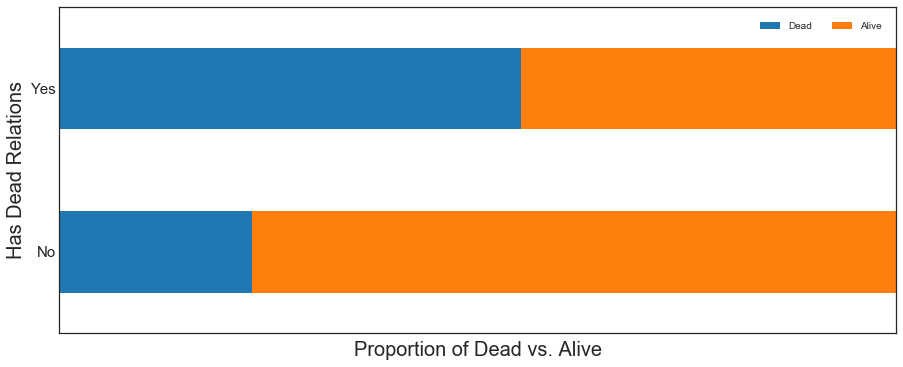

In [52]:
data = character_predictions.groupby(['boolDeadRelations', 'isAlive']).count()[['S.No']].unstack().copy(deep=True) #.plot(kind='barh')

p = data.div(data.sum(axis=1), axis=0).plot(stacked=True, rot=0, width=0.5, kind='barh')

_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", \
                              xlabel = "Proportion of Dead vs. Alive", \
                              ylabel = "Has Dead Relations"), \
                        p.legend(["Dead", "Alive"], loc='upper right', ncol=2, borderpad=1)
_ = plt.savefig('./plots_and_graphs/Survival_vs_Dead.jpeg', bbox_inches='tight')

# plt.xlabel('')
#['S. No.'].plot(kind='barh')

In [53]:
character_predictions.groupby('name')[['isAlive']].count().head()

isAlive
name                     
Abelar Hightower        1
Addam                   1
Addam Frey              1
Addam Marbrand          1
Addam Osgrey            1

## Characters survival with occurrence in most number of Books

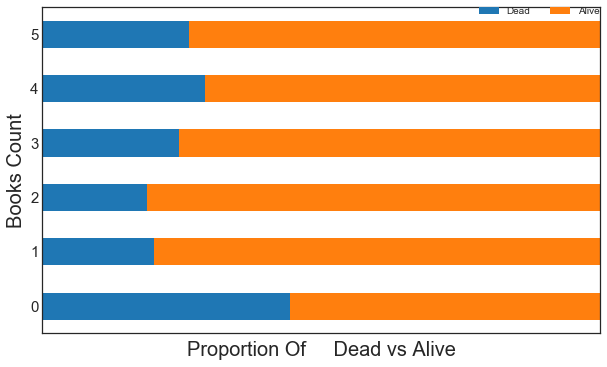

In [54]:
data = character_predictions.groupby(['no_of_books', 'isAlive'])['S.No'].count().unstack() 
#.plot(stacked=True, kind='barh', figsize=(10,6))
p = data.div(data.sum(axis=1), axis=0).plot(stacked=True, kind='barh', figsize=(10,6))
_ = p.set(xticklabels='', xlim=[0, 1], ylabel='Books Count', xlabel='Proportion Of \
    Dead vs Alive'), p.legend(['Dead', 'Alive'], loc='upper right', ncol=2, borderpad=-0.5)
_ = plt.savefig('./plots_and_graphs/Survival_and_Books.jpeg', bbox_inches='tight')

## Army_Size and their Battle outcomes

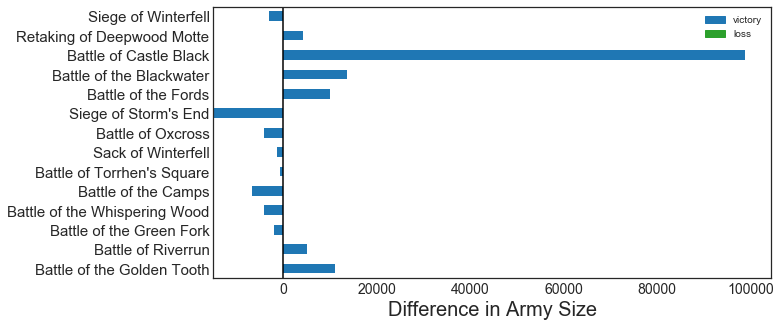

In [55]:
data = battles.dropna(subset=['attacker_size', 'defender_size']).copy(deep=True)
data = concat([(data.attacker_size - data.defender_size).to_frame(), \
               battles[['attacker_outcome']]], axis=1, join='inner')
data = data[data[0] != 0]
p = data[0].plot(kind='barh', figsize=(10,5), color=[sns.color_palette()[0] if x=='win' \
                                                     else sns.color_palette()[2] if \
                                                     x=='loss' else 'white' for x in \
                                                     data.attacker_outcome.values])
_ = p.axvline(0, color='k'), p.set(yticklabels=battles.name.iloc[data.index].values, \
                                   xlabel='Difference in Army Size'), \
                                   p.legend(handles = [mpatches.Patch \
                                                      (color=sns.color_palette()[0], \
                                                      label='victory'), mpatches.Patch \
                                                     (color=sns.color_palette()[2], \
                                                      label='loss')])
_ = plt.savefig('./plots_and_graphs/Army_Size_and_Battles.jpeg', bbox_inches='tight')

In [56]:
battles.attacker_commander.replace(to_replace=np.nan, value='Beric Dondarrion', inplace=True)

In [57]:
battles.attacker_commander

0                                       Jaime Lannister
1                                        Gregor Clegane
2                          Jaime Lannister, Andros Brax
3     Roose Bolton, Wylis Manderly, Medger Cerwyn, H...
4                             Robb Stark, Brynden Tully
5            Robb Stark, Tytos Blackwood, Brynden Tully
6                                        Gregor Clegane
7                                     Victarion Greyjoy
8                                          Asha Greyjoy
9                                         Theon Greyjoy
10                           Rodrik Cassel, Cley Cerwyn
11                                        Theon Greyjoy
12                                      Dagmer Cleftjaw
13                          Ramsay Snow, Theon Greyjoy 
14                            Robb Stark, Brynden Tully
15                    Stannis Baratheon, Davos Seaworth
16    Tywin Lannister, Flement Brax, Gregor Clegane,...
17              Roose Bolton, Vargo Hoat, Robett

## Predictive Analysis

In [58]:
death_pred = character_predictions.copy(deep=True)

In [59]:
death_pred.columns

Index([u'S.No', u'actual', u'pred', u'alive', u'plod', u'name', u'title',
       u'male', u'culture', u'dateOfBirth', u'DateoFdeath', u'mother',
       u'father', u'heir', u'house', u'spouse', u'book1', u'book2', u'book3',
       u'book4', u'book5', u'isAliveMother', u'isAliveFather', u'isAliveHeir',
       u'isAliveSpouse', u'isMarried', u'isNoble', u'age', u'numDeadRelations',
       u'boolDeadRelations', u'isPopular', u'popularity', u'isAlive',
       u'no_of_books'],
      dtype='object')

In [60]:
# death_pred.actual

In [61]:
death_pred.loc[:, 'title'] = factorize(death_pred.loc[:, 'title'])[0]
death_pred.loc[:, 'mother'] = factorize(death_pred.loc[:, 'mother'])[0]
death_pred.loc[:, 'father'] = factorize(death_pred.loc[:, 'father'])[0]
death_pred.loc[:, 'heir'] = factorize(death_pred.loc[:, 'heir'])[0]
death_pred.loc[:, 'house'] = factorize(death_pred.loc[:, 'house'])[0]
death_pred.loc[:, 'spouse'] = factorize(death_pred.loc[:, 'spouse'])[0]

death_pred.drop(['name', 'pred', 'plod', 'culture', 'dateOfBirth'], 1, inplace=True)
death_pred.columns = map(lambda x:x.replace('.', '').replace('_', ''), death_pred.columns)
death_pred.fillna(value=-1, inplace=True)

## Class Distribution of Dead and Alive

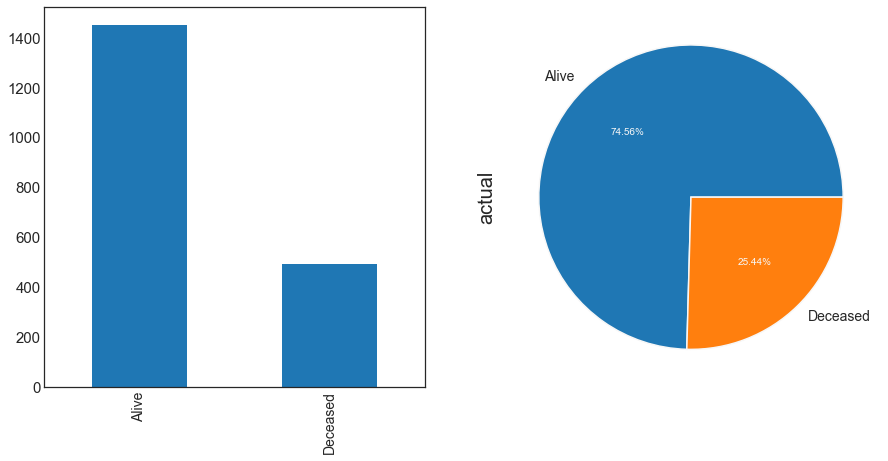

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
p = death_pred.actual.value_counts().plot(kind='bar', ax=ax[0], color=(sns.color_palette()[0], sns.color_palette()[2]))
_ = p.set(xticklabels=['Alive', 'Deceased'])
_ = death_pred.actual.value_counts().plot(kind='pie', ax=ax[1], autopct='%.2f%%', labels=['Alive', 'Deceased'], \
colors = (sns.color_palette()[0], sns.color_palette()[1]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}) , ax[1].texts[1].set_color("#F7F7F7"), \
            ax[1].texts[3].set_color("#F7F7F7")
_ = plt.savefig('./plots_and_graphs/Class_Distribution.jpeg', bbox_inches='tight')

In [63]:
X = death_pred[death_pred.actual == 0].sample(350, random_state=62)
X = X.append(death_pred[death_pred.actual == 1].sample(350, random_state=62).copy(deep=True).astype(np.float64))
Y = X.actual.values
tX = death_pred[~death_pred.index.isin(X.index)].copy(deep=True).astype(np.float64)
tY = tX.actual.values
X.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)
tX.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)

In [64]:
tX.head()

alive  title  male  mother  father  heir  house  spouse  book1  book2  \
1   0.387    0.0   1.0    -1.0    -1.0  -1.0    0.0     0.0    1.0    1.0   
2   0.493    1.0   1.0    -1.0    -1.0  -1.0    1.0    -1.0    0.0    0.0   
5   0.021   -1.0   1.0     1.0     1.0   1.0   -1.0    -1.0    0.0    0.0   
9   0.391    1.0   1.0    -1.0    -1.0  -1.0    5.0    -1.0    0.0    0.0   
11  0.985   -1.0   0.0    -1.0    -1.0  -1.0   -1.0    -1.0    0.0    0.0   

      ...      isAliveSpouse  isMarried  isNoble   age  numDeadRelations  \
1     ...                1.0        1.0      1.0  97.0               1.0   
2     ...               -1.0        0.0      1.0  -1.0               0.0   
5     ...               -1.0        0.0      0.0  -1.0               5.0   
9     ...               -1.0        0.0      1.0  -1.0               0.0   
11    ...               -1.0        0.0      0.0  -1.0               0.0   

    boolDeadRelations  isPopular  popularity  isAlive  noofbooks  
1                 1.0        1.0    0.896321      1.0        5.0  
2                 0.0        0.0    0.267559      1.0        1.0  
5                 1.0        1.0    1.000000      1.0        0.0  
9                 0.0        0.0    0.020067      1.0        0.0  
11                0.0        0.0    0.003344      1.0        1.0  

[5 rows x 26 columns]

In [65]:
X.head()

alive  title  male  mother  father  heir  house  spouse  book1  book2  \
456   0.193   -1.0   1.0    -1.0    -1.0  -1.0    6.0    -1.0    0.0    0.0   
1921  0.115   -1.0   1.0    -1.0    -1.0  -1.0  100.0    -1.0    1.0    1.0   
1650  0.001   -1.0   0.0    -1.0    -1.0  -1.0   89.0    -1.0    0.0    0.0   
1547  0.060    1.0   1.0    -1.0    -1.0  -1.0  314.0    -1.0    1.0    1.0   
1829  0.082  247.0   1.0    -1.0    -1.0  -1.0    4.0    -1.0    1.0    1.0   

        ...      isAliveSpouse  isMarried  isNoble    age  numDeadRelations  \
456     ...               -1.0        0.0      0.0   -1.0               0.0   
1921    ...               -1.0        0.0      0.0    1.0               1.0   
1650    ...               -1.0        0.0      0.0  100.0               0.0   
1547    ...               -1.0        0.0      1.0   -1.0               0.0   
1829    ...               -1.0        0.0      1.0   22.0              11.0   

      boolDeadRelations  isPopular  popularity  isAlive  noofbooks  
456                 0.0        0.0    0.030100      0.0        1.0  
1921                1.0        0.0    0.107023      0.0        3.0  
1650                0.0        0.0    0.050167      0.0        1.0  
1547                0.0        0.0    0.120401      0.0        3.0  
1829                1.0        1.0    0.622074      0.0        5.0  

[5 rows x 26 columns]

In [68]:
clf = XGBC(subsample=.8, colsample_bytree=.8, seed=14, max_depth=3)
# clf = RFECV(clf, step=1, cv=5)
clf = clf.fit(X, Y)

In [69]:
preds_xgb = clf.predict_proba(tX)
preds_xgb

array([[ 0.00895852,  0.99104148],
       [ 0.00471467,  0.99528533],
       [ 0.05271304,  0.94728696],
       ..., 
       [ 0.99642253,  0.00357748],
       [ 0.00417382,  0.99582618],
       [ 0.0035795 ,  0.9964205 ]], dtype=float32)

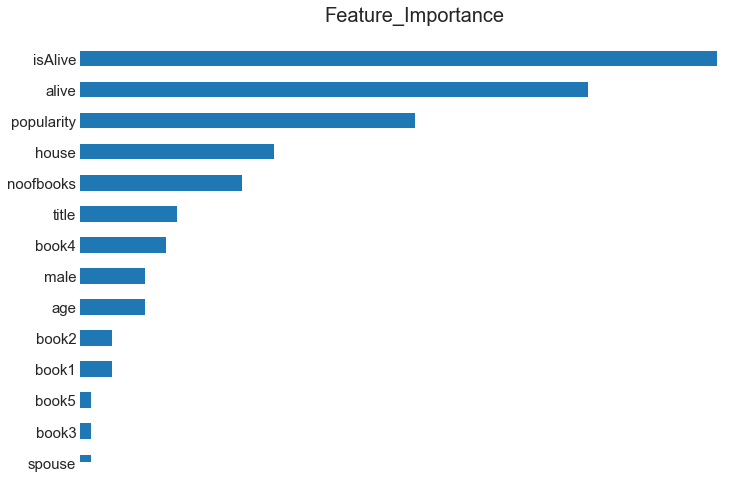

In [70]:
# RFECV doesnt performed well and set ranking for all the features as 1
fscore = list(clf.booster().get_fscore().items())
dataframe = DataFrame(fscore).set_index(0).sort_values(1)
p = dataframe.plot(kind='barh', figsize = (12, 8))
_ = p.set(frame_on=False, ylabel="", ylim=[0, len(clf.booster().get_fscore())], xticklabels=""), p.legend('')
_ = plt.title('Feature_Importance')
_ = plt.savefig('./plots_and_graphs/Feature_Importance.jpeg', bbox_inches='tight')

## Confusion Matrix

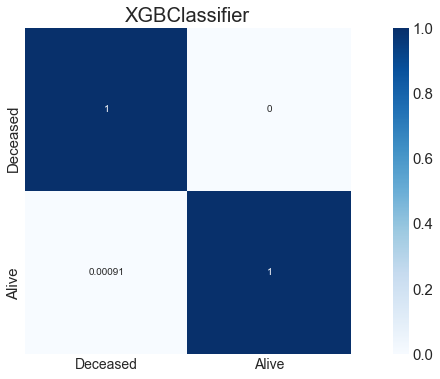

In [71]:
cm = confusion_matrix(tY, np.argmax(preds_xgb, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(cm, square=True, annot=True, cmap='Blues').set(xticklabels=['Deceased', 'Alive'], \
                                                               yticklabels=['Deceased', 'Alive'], title="XGBClassifier")
_ = plt.savefig('./plots_and_graphs/XGBC_Confusion_Matrix.jpeg', bbox_inches='tight')

## Logistic Regression

In [72]:
clf = LogisticRegression(fit_intercept=True, penalty='l1')

In [73]:
clf = clf.fit(X, Y)
prediction_probability = clf.predict_proba(tX)

## Confusion Matrix

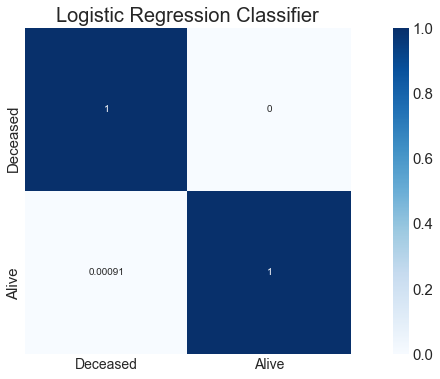

In [74]:
cm = confusion_matrix(tY, np.argmax(prediction_probability, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(cm, square=True, annot=True, cmap='Blues').set(xticklabels=['Deceased', 'Alive'], \
                                                               yticklabels=['Deceased', 'Alive'], \
                                                               title="Logistic Regression Classifier")
_ = plt.savefig('./plots_and_graphs/Logistic_Regression_Confusion_Matrix.jpeg', bbox_inches='tight')

## ROC_AUC Curve

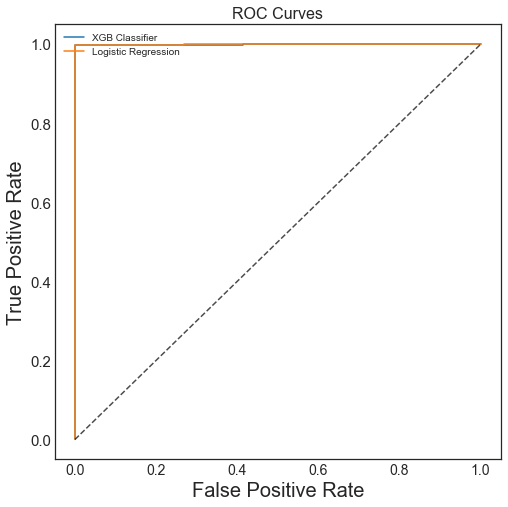

In [75]:
_ = plt.figure(figsize=(8, 8)), plt.plot(*roc_curve(tY, preds_xgb[:,1])[:2]), \
    plt.plot(*roc_curve(tY, prediction_probability[:, 1])[:2], c = sns.color_palette()[1]), \
    plt.legend(["XGB Classifier", "Logistic Regression"], loc = "upper left")
_ = plt.plot((0, 1), (0, 1), "--k", alpha = .7), plt.xlabel("False Positive Rate"), \
    plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)
_ = plt.savefig('./plots_and_graphs/ROC_Curves.jpeg', bbox_inches='tight')